In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
%load_ext autoreload
%autoreload 2

In [5]:

df_c = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_d = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_r = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
def make_data(df):
    df.set_index(['Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = (df.
         stack().
        reset_index().
        rename(columns={'level_4':'issue_date', 0:'cant', 'Country/Region':'Country'})
    )
    df = df.groupby(['Country','issue_date']).sum().drop(['Lat','Long'], axis=1).reset_index()
    df.issue_date = pd.to_datetime(df.issue_date)
    df = df.set_index(['issue_date','Country']).unstack()
    df = df.loc[:, 'cant']
    return df

In [6]:
df_c = make_data(df_c)
df_d = make_data(df_d)
df_r = make_data(df_r)
df_rate = (df_d / df_c).fillna(0).replace(np.inf, 0)
df_act = df_c - df_d - df_r

In [51]:
PAIS = 'Italy'
data = df_act[PAIS][df_act[PAIS]>=1000].values

# A grid of time points (in days)
times = np.linspace(0, len(data), len(data))

## SIR model

In [83]:
import Python.sir_ode as sir_ode
import Python.sir_cost as sir_cost
import Python.minifim as minifim
import Python.proflike as proflike
from scipy.integrate import odeint as ode
import scipy.optimize as optimize
import scipy.stats as stats

In [47]:
#### Set initial parameter values and initial states ####
params = [0.8, 1/9, 10000.0]#make sure all the params and inition states are float
paramnames = ['beta', 'gamma', 'k']
ini = sir_ode.x0fcn(params,data)
print(ini)


[0.8947, 0.1053, 0.0]


In [53]:
res = ode(sir_ode.model, ini, times, args=(params,))

In [27]:
def plot_sir(S, I , R):
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    #ax = fig.add_subplot(111, axis_bgcolor='#dddddd', axisbelow=True)
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()


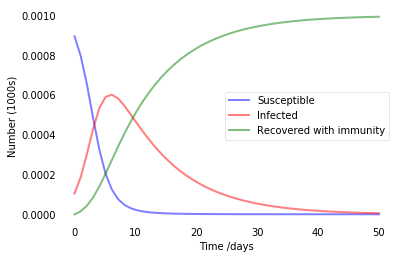

In [56]:
#res = odeint(sir_ode.model, ini, t, args=(params,))
S, I , R = res.T
plot_sir(S, I , R)

[[8.94700000e-01 1.05300000e-01 0.00000000e+00]
 [7.95704652e-01 1.88009181e-01 1.62861666e-02]
 [6.52148323e-01 3.03932738e-01 4.39189390e-02]
 [4.82836566e-01 4.31495350e-01 8.56680846e-02]
 [3.24602124e-01 5.34580070e-01 1.40817806e-01]
 [2.04378431e-01 5.90550034e-01 2.05071535e-01]
 [1.25304362e-01 6.01675791e-01 2.73019846e-01]
 [7.71599210e-02 5.82477793e-01 3.40362285e-01]
 [4.86268669e-02 5.46885347e-01 4.04487786e-01]
 [3.16547881e-02 5.04234334e-01 4.64110878e-01]
 [2.13569520e-02 4.59877743e-01 5.18765305e-01]
 [1.49356984e-02 4.16629129e-01 5.68435173e-01]
 [1.08101551e-02 3.75856299e-01 6.13333546e-01]
 [8.07906246e-03 3.38141504e-01 6.53779434e-01]
 [6.21856893e-03 3.03649738e-01 6.90131693e-01]
 [4.91679959e-03 2.72328979e-01 7.22754222e-01]
 [3.98326749e-03 2.44018606e-01 7.51998126e-01]
 [3.29860344e-03 2.18508314e-01 7.78193083e-01]
 [2.78613385e-03 1.95570161e-01 8.01643705e-01]
 [2.39543210e-03 1.74975938e-01 8.22628630e-01]
 [2.09258993e-03 1.56506343e-01 8.414010

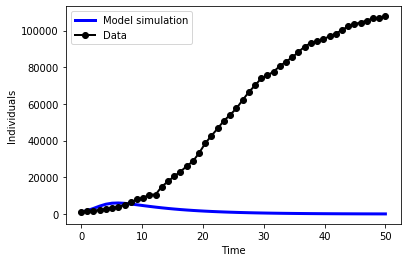

In [57]:
#### Simulate and plot the model ####
res = ode(sir_ode.model, ini, times, args=(params,))
print(res)
sim_measure = sir_ode.yfcn(res, params)
print(sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

In [70]:
#### Parameter estimation ####
optimizer = optimize.minimize(sir_cost.NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = sir_ode.x0fcn(paramests, data)

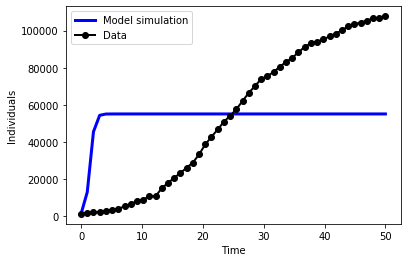

In [71]:
#### Re-simulate and plot the model with the final parameter estimates ####
xest = ode(sir_ode.model, iniests, times, args=(paramests,))
est_measure = sir_ode.yfcn(xest, paramests)
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

In [76]:
#### Calculate the simplified Fisher Information Matrix (FIM) ####
FIM = minifim.minifisher(times, params, data, delta = 0.001)
print(np.linalg.matrix_rank(FIM)) #calculate rank of FIM
print(FIM)


3
[[1.57600669e+08 1.35338651e+09 1.72663370e+04]
 [1.35338651e+09 2.80061137e+10 1.15375027e+05]
 [1.72663370e+04 1.15375027e+05 2.47789170e+00]]


Starting profile...
0 2.6898627826878156
0 2.6151443720575984
0 2.5404259614273816
0 2.4657075507971644
0 2.390989140166947
0 2.3162707295367304
0 2.241552318906513
0 2.1668339082762964
0 2.092115497646079
0 2.017397087015862
1 2.764581193318033
1 2.8392996039482497
1 2.914018014578467
1 2.988736425208684
1 3.063454835838901
1 3.138173246469118
1 3.212891657099335
1 3.287610067729552
1 3.3623284783597693
10
range(10, 0, -1)
range(10, 0, -1)
[-26707207.881966334, -26709331.039891966, -26711596.467014465, -26714017.31131212, -26716606.901836198, -26719378.9850602, -26722348.17978786, -26725530.70682849, -26728945.37925007, -26732614.792491477, -26705213.97932119, -26703336.541844495, -26701563.149935465, -26699881.930987887, -26698281.730668638, -26696752.25861084, -26695284.195782177, -26693869.26331057, -26692500.252025113]
[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[-26705213.97932119, -26732614.792491477, -26728945.37925007, -26725530.70682849, -26722348.17978786, -26719378.9850602, -26716606.9

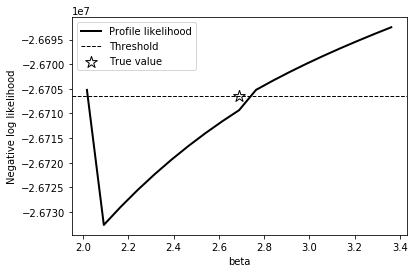

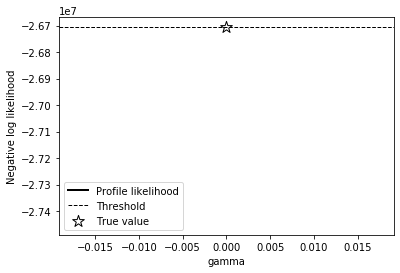

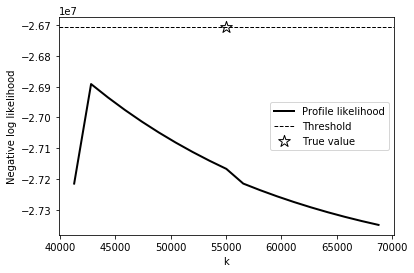

In [126]:
#### Generate profile likelihoods and confidence bounds ####
threshold = stats.chi2.ppf(0.95,len(paramests))/2.0 + optimizer.fun
perrange = 0.25 #percent range for profile to run across

profiles={}
for i in range(len(paramests)):
	profiles[paramnames[i]] = proflike.proflike(paramests, i, sir_cost.NLL, times, data, perrange=perrange)
	plt.figure()
	plt.scatter(paramests[i], optimizer.fun, marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	plt.plot(profiles[paramnames[i]]['profparam'], profiles[paramnames[i]]['fcnvals'], 'k-', linewidth=2, label='Profile likelihood')
	plt.axhline(y=threshold, ls='--',linewidth=1.0, label='Threshold', color='k')
	plt.xlabel(paramnames[i])
	plt.ylabel('Negative log likelihood')
	plt.legend(scatterpoints = 1)
	paramnames_fit = [ n for n in paramnames if n not in [paramnames[i]]]
	paramests_fit = [v for v in paramests if v not in [paramests[i]]]
	print(paramnames_fit)
	print(paramests_fit)

	#plot parameter relationships
	#for j in range(profiles[paramnames[i]]['fitparam'].shape[1]):
	#	plt.figure()
	#	plt.plot(profiles[paramnames[i]]['profparam'],profiles[paramnames[i]]['fitparam'][:,j],'k-', linewidth=2, label=paramnames_fit[j])
	#	plt.scatter(paramests[i], paramests_fit[j], marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	#	plt.xlabel(paramnames[i])
	#	plt.ylabel(paramnames_fit[j])
	#	plt.legend(scatterpoints = 1)
print(profiles)
plt.show()

In [124]:
[i for i in range(9, -1, -1)]

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [104]:
profiles

{'beta': {'profparam': [2.017397087015862,
   2.092115497646079,
   2.1668339082762964,
   2.241552318906513,
   2.3162707295367304,
   2.390989140166947,
   2.4657075507971644,
   2.5404259614273816,
   2.6151443720575984,
   2.6898627826878156,
   2.764581193318033,
   2.8392996039482497,
   2.914018014578467,
   2.988736425208684,
   3.063454835838901,
   3.138173246469118,
   3.212891657099335,
   3.287610067729552,
   3.3623284783597693],
  'fitparam': array([[5.04117742e-17, 5.70585727e+04],
         [4.86321425e-17, 5.69553394e+04],
         [4.74852165e-17, 5.68590575e+04],
         [4.81249444e-17, 5.67690146e+04],
         [4.58487063e-17, 5.66846792e+04],
         [4.47609150e-17, 5.66056866e+04],
         [4.19071902e-17, 5.65317778e+04],
         [3.90056126e-17, 5.64627485e+04],
         [4.02551004e-17, 5.63983989e+04],
         [4.18465786e-17, 5.63385378e+04],
         [4.83913630e-17, 5.62829367e+04],
         [4.78086626e-17, 5.62313155e+04],
         [5.24675048e-17

In [7]:
def SSE(y_true, y_pred):
    return (np.square(y_true - y_pred)).sum()

In [8]:
PAIS = 'Italy'
act = df_act[PAIS][df_act[PAIS]>=1000].values

In [9]:
# Total population, N.
Ns = np.arange(10000, 1000000, 10000)

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1000, 0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
gamma = 1./9
betas = np.linspace(1., 500, 100)/100

# A grid of time points (in days)
t = np.linspace(0, len(act), len(act))

all_result = []
for N in Ns:
    beta_result = [] 

    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    y0 = [S0, I0, R0]

    for beta in betas:        
        S, I, R = solver(deriv, y0, t, (N, beta, gamma))
        beta_result.append(SSE(act, I))
        
    all_result.append(beta_result)
all_result = np.array(all_result)

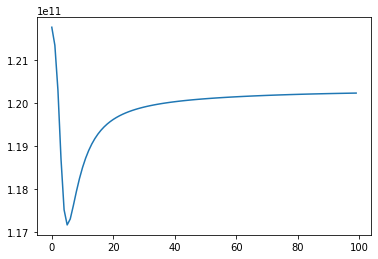

In [10]:
plt.plot(all_result[0]); plt.show()

In [168]:
minN = all_result.min(axis=1).argmin()
minb = all_result.min(axis=0).argmin()
N=Ns[minN]
beta=betas[minb]
print('N: {}, beta:{}'.format(N, beta))

N: 290000, beta:0.31242424242424244


TypeError: odeint() got an unexpected keyword argument 'args'

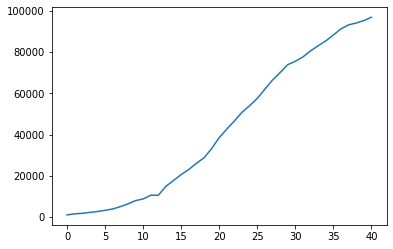

In [22]:
plt.plot(act)
S0 = N - I0 - R0
y0 = [S0, I0, R0]
S, I, R = solver(deriv, y0, t, (N, beta, gamma))
SSE(act, I)
plt.plot(I)
plt.show()

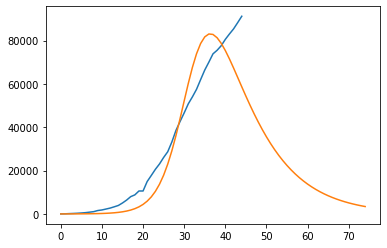

In [164]:
plt.plot(act)
t = np.linspace(0, 75, 75)
S, I, R = solver(deriv, y0, t, (N, beta, gamma))
plt.plot(I); plt.show()

## Use of pytorch ODEint

In [28]:
from torchdiffeq import odeint
import torch.nn as nn

In [25]:
class ODEFunc(nn.Module):
    def __init__(self, N, beta, gamma):
        super(ODEFunc, self).__init__()
        self.N = N
        self.beta = beta
        self.gamma = gamma

    def forward(self, t, y):
        S, I, R = y
        dSdt = -self.beta * S * I / self.N
        dIdt = self.beta * S * I / self.N - self.gamma * I
        dRdt = self.gamma * I
        return dSdt, dIdt, dRdt


In [29]:
deriv = ODEFunc(1000, 0.1, 0.3)
def solver(deriv, y0, t):
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t)
    return ret.T

In [30]:
# Total population, N.
N = 10000000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 100, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.8, 1./9

# A grid of time points (in days)
t = np.linspace(0, 17, 17)
# Initial conditions vector
y0 = torch.tensor([S0, I0, R0])

S, I, R = solver(deriv, y0, t)

AssertionError: y0 must be either a torch.Tensor or a tuple